# AST ESC-50 Model Test

In [ ]:
import os
import torch
import torchaudio
from transformers import ASTFeatureExtractor, ASTForAudioClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

d:\GitHub\SED\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Directory where the model files are stored
model_dir = 'D:\\GitHub\\SED\\notebooks\\AST\\saved_model'

# Ensure the directory exists
assert os.path.exists(model_dir), f"Model directory {model_dir} does not exist."

# Load the feature extractor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = ASTFeatureExtractor.from_pretrained(model_dir)
model = ASTForAudioClassification.from_pretrained(model_dir, use_safetensors=True).to(device)
print("Model and feature extractor loaded successfully from the existing directory.")

# Dataset Directory
dataset_dir = os.getenv("ESC_50_dataset")
assert dataset_dir, "Dataset directory is not set. Please set the environment variable 'ESC_50_dataset'."
assert os.path.exists(dataset_dir), f"Dataset directory {dataset_dir} does not exist."

# Load all audio file paths from the dataset directory
audio_files = glob.glob(os.path.join(dataset_dir, '**', '*.wav'), recursive=True) + \
              glob.glob(os.path.join(dataset_dir, '**', '*.flac'), recursive=True)
assert len(audio_files) > 0, "No audio files found in the dataset directory."

# Function to preprocess audio file
def preprocess_audio(file_path, feature_extractor, target_sampling_rate=16000):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sampling_rate)
        waveform = resampler(waveform)
    inputs = feature_extractor(waveform.numpy(), sampling_rate=target_sampling_rate, return_tensors="pt")
    return inputs['input_values'].squeeze(0)  # Remove batch dimension

# Function to predict the class of an audio file
def predict(file_path, model, feature_extractor):
    model.eval()
    with torch.no_grad():
        input_values = preprocess_audio(file_path, feature_extractor).to(device)
        input_values = input_values.unsqueeze(0)  # Add batch dimension
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        return predicted_ids.item(), logits

Model and feature extractor loaded successfully from the existing directory.


In [ ]:
# Test the model on the entire dataset
results = []
true_labels = []
predicted_labels = []
for file_path in tqdm(audio_files, desc="Testing Model"):
    predicted_label, logits = predict(file_path, model, feature_extractor)
    true_label = int(os.path.basename(file_path).split('-')[-1].split('.')[0])  # Getting the position of the label
    results.append((file_path, true_label, predicted_label))
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

Testing Model: 100%|██████████| 2000/2000 [1:11:03<00:00,  2.13s/it]


In [ ]:
# Display the results
for file, true_label, predicted_label in results:
    print(f"File: {file}, True Label: {true_label}, Predicted Label: {predicted_label}")

File: D:\datasets\ESC-50-master\audio\1-100032-A-0.wav, True Label: 0, Predicted Label: 0
File: D:\datasets\ESC-50-master\audio\1-100038-A-14.wav, True Label: 14, Predicted Label: 14
File: D:\datasets\ESC-50-master\audio\1-100210-A-36.wav, True Label: 36, Predicted Label: 36
File: D:\datasets\ESC-50-master\audio\1-100210-B-36.wav, True Label: 36, Predicted Label: 36
File: D:\datasets\ESC-50-master\audio\1-101296-A-19.wav, True Label: 19, Predicted Label: 19
File: D:\datasets\ESC-50-master\audio\1-101296-B-19.wav, True Label: 19, Predicted Label: 19
File: D:\datasets\ESC-50-master\audio\1-101336-A-30.wav, True Label: 30, Predicted Label: 30
File: D:\datasets\ESC-50-master\audio\1-101404-A-34.wav, True Label: 34, Predicted Label: 34
File: D:\datasets\ESC-50-master\audio\1-103298-A-9.wav, True Label: 9, Predicted Label: 9
File: D:\datasets\ESC-50-master\audio\1-103995-A-30.wav, True Label: 30, Predicted Label: 30
File: D:\datasets\ESC-50-master\audio\1-103999-A-30.wav, True Label: 30, Pre

In [ ]:
# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Performance Metrics:
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F1 Score: 0.9990


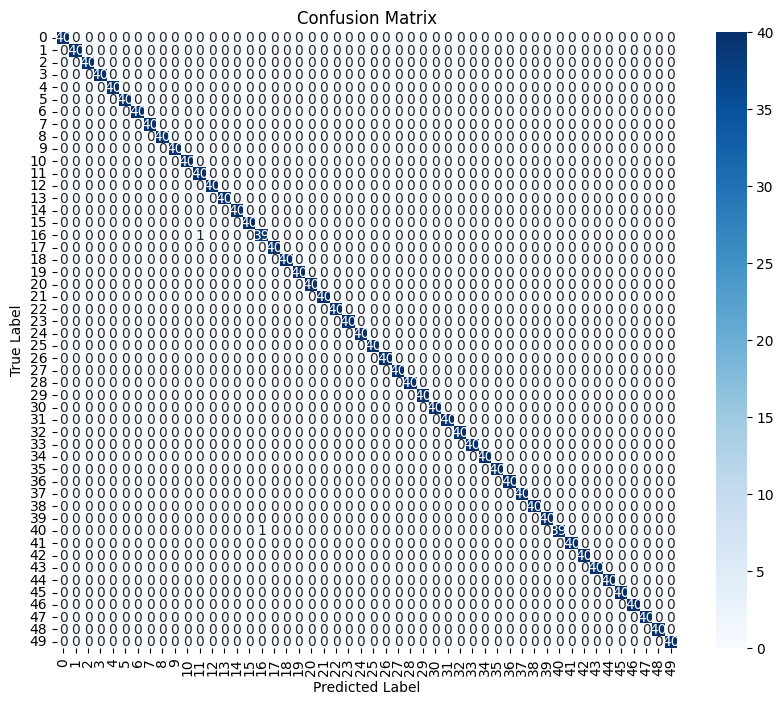

In [ ]:
# Display confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Display classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        40
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        40
           9       1.00      1.00      1.00        40
          10       1.00      1.00      1.00        40
          11       0.98      1.00      0.99        40
          12       1.00      1.00      1.00        40
          13       1.00      1.00      1.00        40
          14       1.00      1.00      1.00        40
          15       1.00      1.00      1.00        40
          16       0.97      0.97      0.97        40
   